In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as sct

import tensorflow as tf
import pickle as pkl
import tensorflow as tf


In [2]:
mean = (0,0) 
cov = [[1, .5], [.5, 1]]
samples = 1000
x = np.random.multivariate_normal(mean, cov, (1, samples))


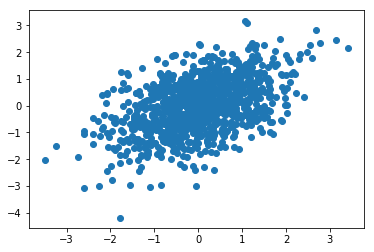

In [3]:
plt.scatter(x[0,:,0],x[0,:,1])
plt.show()

In [4]:
u,v = (sct.norm.cdf(x[0,:,0])),(sct.norm.cdf(x[0,:,1]))

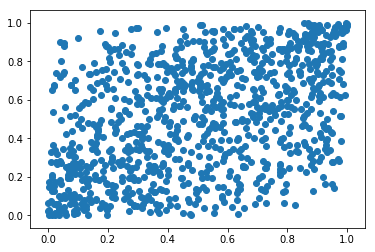

In [5]:
plt.scatter(u,v)
plt.show()

In [6]:
uv_mat =np.transpose(np.array([u,v]))
uv_mat

array([[ 0.31574522,  0.4139809 ],
       [ 0.28639028,  0.04578229],
       [ 0.05413408,  0.87789144],
       ..., 
       [ 0.23295963,  0.27569149],
       [ 0.52146333,  0.49400858],
       [ 0.28063065,  0.11517845]])

In [7]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, 2), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, 2), name='input_z')
    
    return inputs_real, inputs_z

In [8]:
def generator(z, out_dim, n_units=4, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Hidden layer 2
        h2 = tf.layers.dense(h1, n_units, activation=None)
        # Leaky ReLU
        h2 = tf.maximum(alpha * h2, h2)
        
        # Logits and tanh output
        logits = tf.layers.dense(h2, out_dim, activation=None)
        out = tf.sigmoid(logits)
        
        return out

In [9]:
def discriminator(x, n_units=4, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
         # Hidden layer 1
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Hidden layer 2
        h2 = tf.layers.dense(h1, n_units, activation=None)
        # Leaky ReLU
        h2 = tf.maximum(alpha * h2, h2)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [10]:
# Size of input image to discriminator
input_size = 2
# Size of latent vector to generator
z_size = 2
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 8
d_hidden_size = 8
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

In [11]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
# g_model is the generator output

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

In [12]:
# Calculate losses
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

In [13]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [14]:
def batches(uv_mat,batch_size):
    idx = np.arange(len(uv_mat))
    np.random.shuffle(idx)
    train_x = uv_mat[idx]

    n_batches = len(train_x)//batch_size
    for ii in range(0, len(train_x), batch_size):
        x = train_x[ii:ii+batch_size]
        yield np.reshape(x, (batch_size,2))
    

In [23]:
batch_size = 16
epochs = 200
samples = []
losses = []
num_samples = uv_mat.shape[0]
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(num_samples//batch_size):
            batch = next(batches(uv_mat,batch_size))  
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch
             
            # Sample random noise for G
            batch_z = np.random.uniform(0, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(0, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/200... Discriminator Loss: 1.3832... Generator Loss: 0.7345
Epoch 2/200... Discriminator Loss: 1.3064... Generator Loss: 0.7582
Epoch 3/200... Discriminator Loss: 1.2766... Generator Loss: 0.8269
Epoch 4/200... Discriminator Loss: 1.3335... Generator Loss: 0.9939
Epoch 5/200... Discriminator Loss: 1.3431... Generator Loss: 0.8794


KeyboardInterrupt: 

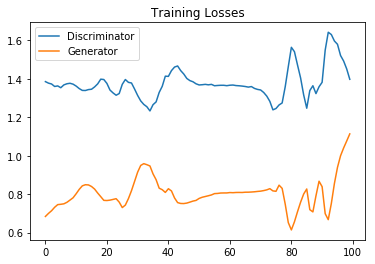

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [17]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

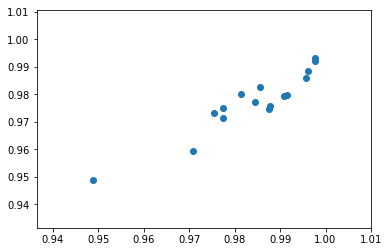

In [18]:
u,v = samples[-1][:,0],samples[-1][:,1]
plt.scatter(u,v)
plt.show()

In [21]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(0, 1, size=(1000, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


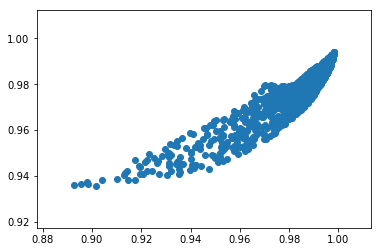

In [22]:
u,v = gen_samples[:,0],gen_samples[:,1]

plt.scatter(u,v)
plt.show()